In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf

import os
import glob
import cv2

## Necessary Functions

Taken from 25_May.ipynb from Colab, only paths are modified

In [5]:
def get_data(methods, n, img_dim = 224):
  '''Reads the data.
  
  Takes 3 arguments:
  1. methods - this is a list containing the which deepfake methods we want
  to read in (can also specify original)
  2. n - number of videos (first n)
  3. img_dim  = 224 - equatest to the length of an image's height and width 
  
  Returns a dictionary with the method and video as the nested keys.
  Each dict value has the following shape:
  (#(images for a video), Height = img_dim, Width = img_dim, #(Channels) = 3)'''


  # path = 'drive/My Drive/Deepfakes Capstone Project/DeepFake-2019-20/images/'
  result = {method : [] for method in methods}
    
  for method in methods:
      if method == 'Original': path = 'original_sequences/youtube/c0/'
      else: path = 'manipulated_sequences/' + method + '/c0/'

      print("Starting to load", method, "images")
      folders =  os.listdir(path + method + '_images')
      folders = sorted(list(set(folders).difference(set(['.DS_Store']))))
      # generate 1000 keys for each method with an empty corresponding value
      result[method] = {folder:[] for folder in folders}

      # only look at the first n videos for a given method
      for folder in folders[0:n]:
          # output progress
          if folder[2] == '0' and folder[1] == '0': print(folder) # every 100th
          # if folder[2] == '0': print(folder) # every 10th
          # print(folder)

          images = []
          full_path = path + method + '_images/' + folder
          # obtain full paths for all images
          images_list = os.listdir(full_path)
          images_list = [full_path + "/" + el for el in images_list]
          
          for el in images_list:
              # [:,:,::-1] bit just saves arrays backwards:
              # reading and writing produces different sequences (RGB vs BGR)
              # omitting it will just output blue images which is not problematic for 
              # networks, hence can be dropped if it becomes more efficient
              img = cv2.imread(el) #[:,:,::-1] 
              # resize so images can be put together in one list
              img_resized=cv2.resize(img,(img_dim,img_dim))
              images.append(img_resized)

          result[method][folder] = np.array(images)

      print("Loading", method, "images is complete\n")

  return result

def extract_images(images, fraction_for_testing):
    '''Takes a dictionary of all images obtained from get_data,
    splits into training and test data, using the specified
    fraction_for_testing (number between 0 and 1), normalises the images and returns 
    all image data in a list, a more useable form for training and testing.
    
    Returns:
    x: a single array of all cropped images for all videos
    (form: (total number of images, height, width, number of channels))

    data: a DataFrame containing the method, video, whether its test/train data,
    the true label and the predicted label for each frame (predicted labels are
    all set to 0 (or Original) as a default).'''

    x = []
    details = []

    for method in images.keys():
        # set the label to be 0 for authentic images and 1 for fakes
        if method == "Original": label = 0
        else: label = 1

        for folder in images[method].keys():
            # build up new, more convinient, separate entries x (array of all images)
            # and details (a list with a method, video title and the true label)
            arr = images[method][folder]
            x += list(arr)
            details += list([[method, folder, label]]*len(arr))
    
    # build up a list with all distinct videos (method, title and true label)
    distinct_videos = []
    for el in details:
      if not el in distinct_videos: distinct_videos.append(el)

    num = len(distinct_videos)
    # get a random sample from all distinct videos, size of desired testing size
    test_videos = random.sample(distinct_videos, int(num*fraction_for_testing))
    # attach a corresponding mark ('test' or 'train')
    details = [el + ['test'] if el in test_videos else el + ['train'] for el in details]
    x = np.array(x); details = np.array(details)

    ## Note: by design images from one video can't end up in both testing and
    # training data because the split was performed by distinct videos -- 
    # meaning that a given video fully belongs to one category only
    # Hence, there is no intercept of any form between testing and training data

    index = range(x.shape[0])
    data = pd.DataFrame(index = index, columns = ['method', 'video', 'test/train',
                                                  'true label', 'predicted label'])
    # filling all predictions as authentic as a default
    # (will be changed later after predictions are obtained)
    data.fillna(0)

    data['method'] = [el[0] for el in details]
    data['video'] = [el[1] for el in details]
    data['true label'] = [el[2] for el in details]
    data['test/train'] = [el[3] for el in details]

    x = x.astype('float32')
    x /= 255 # normalise

    print("Image array shape:", x.shape)

    return x, data

def extract_labels(data):
    '''Takes the dataframe created from extract_images and returns the true labels for 
    each cropped image, in the categorical format required for training a network
    
    the labels are of two categories: convention is 0 for fake and 1 otherwise'''

    labels = data['true label']; labels = np.array(labels)
    # two categories: original/authentic -- 0, fake -- 1
    labels = tf.keras.utils.to_categorical(labels, 2)
    print("Labels shape:", labels.shape)
    return labels

## New Functions

Written based on 25_May.ipynb (*run_prep* function and saving example from one of the earlier sections)

In [3]:
def get_arrays(methods, n, img_dim = 224, fraction_for_testing = 0.1):
    '''Reads images from drive into dictionary and array formats, generates
    a required dataframe to compute video accuracy later
    
    Inputs:
    1. methods -- a list with elements chosen from ['Original', 'Deepfakes',
    'Face2Face', 'FaceSwap', 'NeuralTextures'] -- at least one representative
    from each class is required
    2. n -- number of videos to be selected from each method (first n videos)
    3. img_dimension -- all images are of their original size, to put them into
    a single array they are resized to be of the same dimension
    4. fraction_for_testing -- (number between 0 and 1), how much data to 
    reserve for testing during splitting (note: split by videos, not images
    so no video can be partially split between training and testing categories)'''

    # get a complete dicstionary of information
    images = get_data(methods, n, img_dim)
    # remould information into separate entries
    x, df = extract_images(images, fraction_for_testing)
    labels = extract_labels(df)

    return x, labels, df

def save_arrays(x, df, method):
    np.save("arrays/" + method + "_images.npy", x)
    df.to_csv("arrays/" + method + '_df.csv')

## Example

Taken from Greg's latest addition to 25_May.ipynb

In [5]:
for i in ['Original','Deepfakes','FaceSwap','Face2Face', 'NeuralTextures']:
    print(i)
    x_i, labels_i, df_i = get_arrays([i], 2, 224, 0.1)
    save_arrays(x_i, df_i, i)

Original
Starting to load Original images
000
Loading Original images is complete

Image array shape: (58, 224, 224, 3)
Labels shape: (58, 2)
Deepfakes
Starting to load Deepfakes images
000_003
Loading Deepfakes images is complete

Image array shape: (27, 224, 224, 3)
Labels shape: (27, 2)
FaceSwap
Starting to load FaceSwap images
000_003
Loading FaceSwap images is complete

Image array shape: (52, 224, 224, 3)
Labels shape: (52, 2)
Face2Face
Starting to load Face2Face images
000_003
Loading Face2Face images is complete

Image array shape: (62, 224, 224, 3)
Labels shape: (62, 2)
NeuralTextures
Starting to load NeuralTextures images
000_003
Loading NeuralTextures images is complete

Image array shape: (52, 224, 224, 3)
Labels shape: (52, 2)


## Testing Saved Arrays

Based on the function from earlier section in 25_may.ipynb (now tested)

In [6]:
def load_arrays_and_dataframe(methods):
    '''This function loads image and label arrays, and dataframe for the 
    requested methods (Original is included because must have a representative
    for each class)
    
    Returns images (also refered to as x through the script), labels and join 
    dataframe storing all the information
    
    After this, only shuffle and split functions are required to complete the 
    "Prepping the Materials" section'''

    # start with Original images and read array for every other requested method
    other_methods = list(set(methods).difference(set(['Original'])))
    
    images = np.load('arrays/Original_images.npy')
    for method in other_methods:
        more_images = np.load('arrays/' + method + '_images.npy')
        images = np.concatenate((images, more_images))

    df = pd.read_csv('arrays/Original_df.csv')
    for method in other_methods:
        another_df = pd.read_csv('arrays/' + method + '_df.csv')
        df = pd.concat([df, another_df])

    return images, df.drop(['Unnamed: 0'], axis=1)

images, df = load_arrays_and_dataframe(methods = ['Original','Deepfakes','FaceSwap','Face2Face', 'NeuralTextures'])

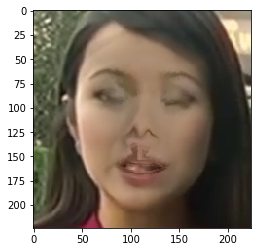

In [7]:
# [:,:,::-1] reverses the order of pixels: reading and saving have different order for colours
plt.imshow(images[100][:,:,::-1])

In [8]:
display(df[20:30])

,method,video,test/train,true label,predicted label
20,Original,0,train,0,NaN
21,Original,0,train,0,NaN
22,Original,0,train,0,NaN
23,Original,0,train,0,NaN
24,Original,0,train,0,NaN
25,Original,0,train,0,NaN
26,Original,0,train,0,NaN
27,Original,1,train,0,NaN
28,Original,1,train,0,NaN
29,Original,1,train,0,NaN


## Saving Arrays

Final run which produces the data which we will be using

Done separately for each method due to kernel timeout

Based on Greg's latest addition to 25_May.ipynb

In [4]:
for i in ['Original']:
    print(i)
    x_i, labels_i, df_i = get_arrays([i], 1000, 224, 0.1)
    save_arrays(x_i, df_i, i)

Original
Starting to load Original images
000
100
200
300
400
500
600
700
800
900
Loading Original images is complete

Image array shape: (34399, 224, 224, 3)
Labels shape: (34399, 2)


In [6]:
for i in ['Deepfakes']:
    print(i)
    x_i, labels_i, df_i = get_arrays([i], 1000, 224, 0.1)
    save_arrays(x_i, df_i, i)

Deepfakes
Starting to load Deepfakes images
000_003
100_077
200_189
300_304
400_476
500_592
600_505
700_813
800_840
900_926
Loading Deepfakes images is complete

Image array shape: (34390, 224, 224, 3)
Labels shape: (34390, 2)


In [4]:
for i in ['FaceSwap']:
    print(i)
    x_i, labels_i, df_i = get_arrays([i], 1000, 224, 0.1)
    save_arrays(x_i, df_i, i)

FaceSwap
Starting to load FaceSwap images
000_003
100_077
200_189
300_304
400_476
500_592
600_505
700_813
800_840
900_926
Loading FaceSwap images is complete

Image array shape: (27541, 224, 224, 3)
Labels shape: (27541, 2)


In [4]:
for i in ['Face2Face']:
    print(i)
    x_i, labels_i, df_i = get_arrays([i], 1000, 224, 0.1)
    save_arrays(x_i, df_i, i)

Face2Face
Starting to load Face2Face images
000_003
100_077
200_189
300_304
400_476
500_592
600_505
700_813
800_840
900_926
Loading Face2Face images is complete

Image array shape: (34401, 224, 224, 3)
Labels shape: (34401, 2)


In [4]:
for i in ['NeuralTextures']:
    print(i)
    x_i, labels_i, df_i = get_arrays([i], 1000, 224, 0.1)
    save_arrays(x_i, df_i, i)

NeuralTextures
Starting to load NeuralTextures images
000_003
100_077
200_189
300_304
400_476
500_592
600_505
700_813
800_840
900_926
Loading NeuralTextures images is complete

Image array shape: (27542, 224, 224, 3)
Labels shape: (27542, 2)
